[[이유한님] 캐글 코리아 캐글 스터디 커널 커리큘럼](https://kaggle-kr.tistory.com/32)  
[타이타닉 캐글 링크](https://www.kaggle.com/c/titanic)

# [Titanic Top 4% with ensemble modeling](https://www.kaggle.com/code/yassineghouzam/titanic-top-4-with-ensemble-modeling)  
__Yassine Ghouzam, PhD__  
  
13/07/2017  
  
- __1 Introduction__
- __2 Load and check data__
    - 2.1 load data
    - 2.2 Outlier detection
    - 2.3 joining train and test set
    - 2.4 check for null and missing values
- __3 Feature analysis__
    - 3.1 Numerical values
    - 3.2 Categorical values
- __4 Filling missing Values__
    - 4.1 Age
- __5 Feature engineering__
    - 5.1 Name/Title
    - 5.2 Family Size
    - 5.3 Cabin
    - 5.4 Ticket
- __6 Modeling__
    - 6.1 Simple modeling
        - 6.1.1 Cross validate models
        - 6.1.2 Hyperparamater tunning for best models
        - 6.1.3 Plot learning curves
        - 6.1.4 Feature importance of the tree based classifiers
    - 6.2 Ensemble modeling
        - 6.2.1 Combining models
    - 6.3 Prediction
        - 6.3.1 Predict and Submit results

# 1. Introduction
This is my first kernel at Kaggle. I choosed the Titanic competition which is a good way to introduce feature engineering and ensemble modeling. Firstly, I will display some feature analyses then ill focus on the feature engineering. Last part concerns modeling and predicting the survival on the Titanic using an voting procedure.  
  
This script follows three main parts:  
  
- __Feature analysis__
- __Feature engineering__
- __Modeling__

# DeepL 번역
이것은 Kaggle에서의 첫 번째 커널입니다. 저는 피처 엔지니어링과 앙상블 모델링을 소개하기 좋은 타이타닉 대회를 선택했습니다. 먼저 몇 가지 특징 분석을 보여준 다음 특징 엔지니어링에 대해 집중적으로 설명하겠습니다. 마지막 부분은 투표 절차를 사용하여 타이타닉의 생존율을 모델링하고 예측하는 것입니다.  
  
이 스크립트는 크게 세 부분으로 구성됩니다:  
  
- __특징 분석__
- __기능 엔지니어링__
- __모델링__

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
# get_ipython().run_line_magic('matplotlib', 'inline')

from collections import Counter

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis    #  LDA(선형 판별 분석): 정규분포와 서로 같은 공분산 구조를 가정한 군집 분류
# from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis # QDA(이차 판별 분석): 서로 다른 공분산 구조를 가정한 군집 분류
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

# sns.set(style='white', context='notebook', palette='deep')

import warnings
warnings.filterwarnings('ignore')

# 2. Load and check data
## 2.1 Load data

In [51]:
# Load data
##### Load train and Test set

train = pd.read_csv('./input/001_titanic/train.csv')
test = pd.read_csv('./input/001_titanic/test.csv')
IDtest = test['PassengerId']

## 2.2 Outlier detection

In [52]:
# Outlier detection
def detect_outliers(df, n, features):
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than n outliers according
    to the Tukey method.
    """
    outlier_indices = []

    # iterate over features(columns)
    for col in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col], 75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1

        # outlier step
        outlier_step = 1.5 * IQR

        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1-outlier_step) | (df[col] > Q3+outlier_step)].index

        # append the found outlier indices for col to the list of outlier indices
        outlier_indices.extend(outlier_list_col)

    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)
    multiple_outliers = list(k for k, v in outlier_indices.items() if v>n)

    return multiple_outliers

# detect outliers from Age, SibSp, Parch and Fare
Outliers_to_drop = detect_outliers(train, 2, ['Age', 'SibSp', 'Parch', 'Fare'])

Since outliers can have a dramatic effect on the prediction (espacially for regression problems), i choosed to manage them.  
  
I used the Tukey method (Tukey JW., 1977) to detect ouliers which defines an interquartile range comprised between the 1st and 3rd quartile of the distribution values (IQR). An outlier is a row that have a feature value outside the (IQR +- an outlier step).  
  
I decided to detect outliers from the numerical values features (Age, SibSp, Sarch and Fare). Then, i considered outliers as rows that have at least two outlied numerical values.  
  
__DeepL 번역__  
이상값은 예측에 큰 영향을 미칠 수 있으므로(특히 회귀 문제의 경우) 이상값을 관리하기로 결정했습니다.  
  
저는 분포 값의 1사분위수에서 3사분위수 사이로 구성된 사분위수 간 범위(IQR)를 정의하는 Tukey 방법(Tukey JW., 1977)을 사용하여 이상값을 감지했습니다. 이상값은 (IQR +- an outlier step)을 벗어나는 특징값을 가진 행입니다.  
  
저는 숫자 값 특징(Age, SibSp, Sarch 및 Fare)에서 이상값을 감지하기로 결정했습니다. 그런 다음 이상값이 두 개 이상 있는 행을 이상값으로 간주했습니다.

In [53]:
train.loc[Outliers_to_drop] # Show the outliers rows

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.00,C23 C25 C27,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.00,C23 C25 C27,S
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.00,C23 C25 C27,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S


In [54]:
# We detect 10 outliers. The 28, 89 and 342 passenger have an high Ticket Fare
# The 7 others have very high values of SibSP.

# Drop outliers

train = train.drop(Outliers_to_drop, axis=0).reset_index(drop=True)

## 2.3 joining train and test set

In [55]:
## Join train and test datasets in order to obtain the same number of features during categoricla conversion
train_len = len(train)
dataset = pd.concat(objs=[train, test], axis=0).reset_index(drop=True)

# I join train and test datasets to obtain the same number of features during categorical conversion
# (See feature engineering).

## 2.4 check for null and missing values

In [56]:
# Fill empty and NaNs values with NaN
dataset = dataset.fillna(np.nan)

# Check for Null values
dataset.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             256
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1007
Embarked          2
dtype: int64

Age and Cabin features have an important part of missing values.  
  
__Survived missing values correspond to the join testing dataset (Survived column doesn't exist in test set and has been replace by NaN values when concatenating the train and test set)__

In [57]:
# Infos
train.info()
train.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 881 entries, 0 to 880
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  881 non-null    int64  
 1   Survived     881 non-null    int64  
 2   Pclass       881 non-null    int64  
 3   Name         881 non-null    object 
 4   Sex          881 non-null    object 
 5   Age          711 non-null    float64
 6   SibSp        881 non-null    int64  
 7   Parch        881 non-null    int64  
 8   Ticket       881 non-null    object 
 9   Fare         881 non-null    float64
 10  Cabin        201 non-null    object 
 11  Embarked     879 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 82.7+ KB


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            170
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          680
Embarked         2
dtype: int64

In [58]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [59]:
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [60]:
### Summarize data
# Summarie and statistics
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,881.000000,881.000000,881.000000,711.000000,881.000000,881.000000,881.000000
mean,446.713961,0.385925,2.307605,29.731603,0.455165,0.363224,31.121566
std,256.617021,0.487090,0.835055,14.547835,0.871571,0.791839,47.996249
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,226.000000,0.000000,2.000000,20.250000,0.000000,0.000000,7.895800
50%,448.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.000000,1.000000,3.000000,38.000000,1.000000,0.000000,30.500000
max,891.000000,1.000000,3.000000,80.000000,5.000000,6.000000,512.329200


# 3.Feature analysis
## 3.1 Numerical values

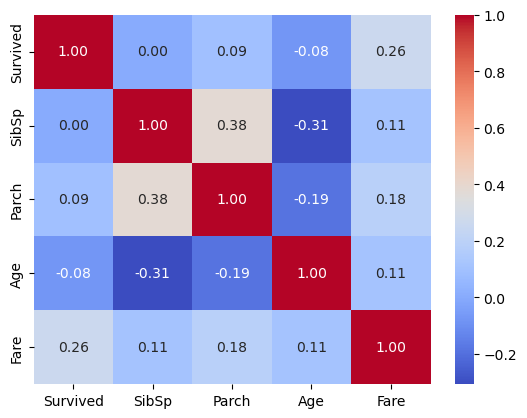

In [61]:
# Correlation matrix beween numerical values (SibSp Parch Age and Fare values) and Survived

g = sns.heatmap(train[['Survived', 'SibSp', 'Parch', 'Age', 'Fare']].corr(), annot=True, fmt='.2f', cmap='coolwarm')

Only Fare feature seems to have a significative correlation with the survival probability.
  
It doesn't mean that the other features are not usefull. Subpopulations in these features can be correlated with the survival. To determine this, we need to explore in detail these features  
  
__SibSP__

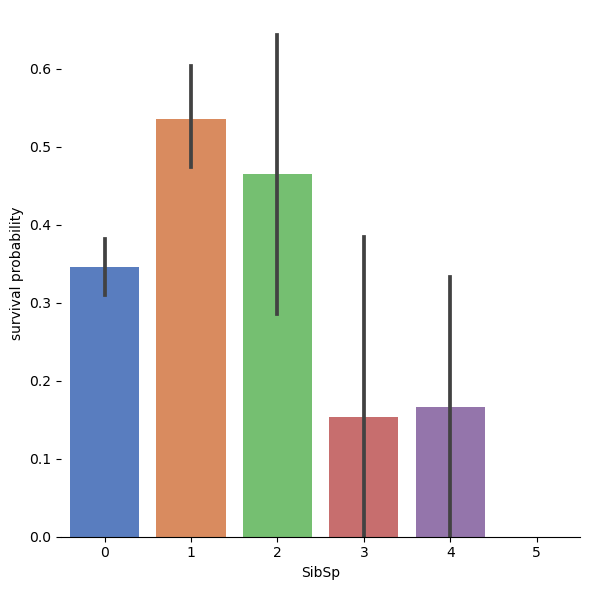

In [62]:
# Explore SibSp feature vs Survived

# g = sns.factorplot(x='SibSp', y='Survived', data=train, kind='bar', size=6, palette='muted')
# 함수 변경
g = sns.catplot(x='SibSp', y='Survived', data=train, kind='bar', height=6, palette='muted')
g.despine(left=True)    # 그래프 외곽선? 제거 설정
g = g.set_ylabels('survival probability')

It seems that passengers having a lot of siblings/spouses have less chance to survive  
  
Single passengers (0 SibSP) or with two other persons (SibSP 1 or 2) have more chance to survive  
  
This observation is quite interesting, we can consider a new feature describing these categories (See feature engineering)  
  
__Parch__

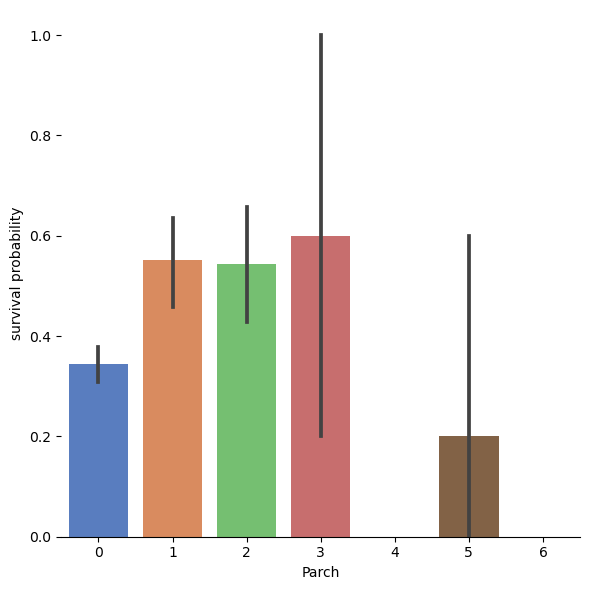

In [63]:
# Explore Parch feature vs Survived

# g = sns.factorplot(x='Parch', y='Survived', data=train, kind='bar', size=6, palette='muted')
# 함수 변경
g = sns.catplot(x='Parch', y='Survived', data=train, kind='bar', height=6, palette='muted')
g.despine(left=True)
g = g.set_ylabels('survival probability')

Small families have more chance to survive, more than single (Parch 0), medium (Parch 3,4) and large families (Parch 5,6 ).  
  
Be carefull there is an important standard deviation in the survival of passengers with 3 parents/children  
  
__Age__

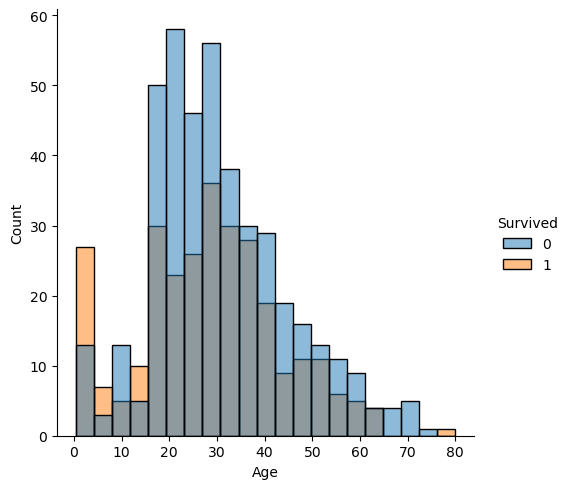

In [64]:
sns.displot(data=train, x='Age', hue='Survived');

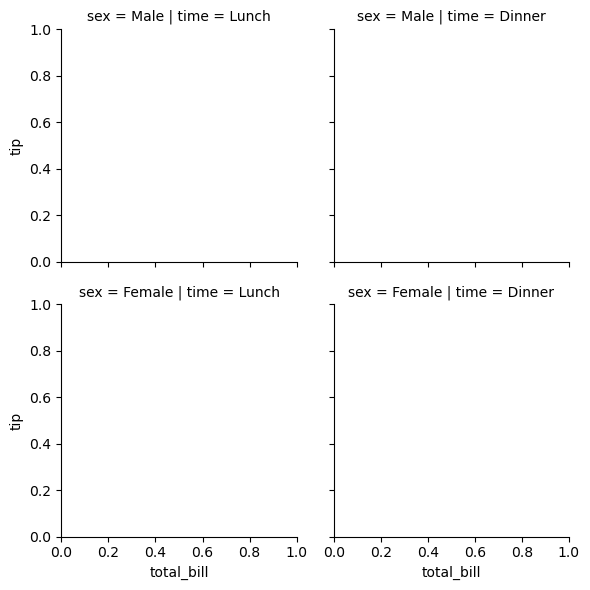

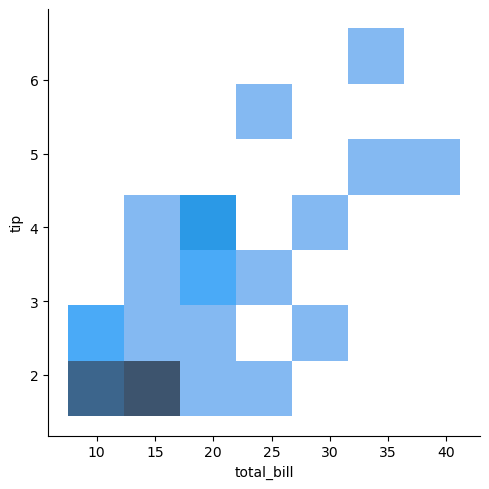

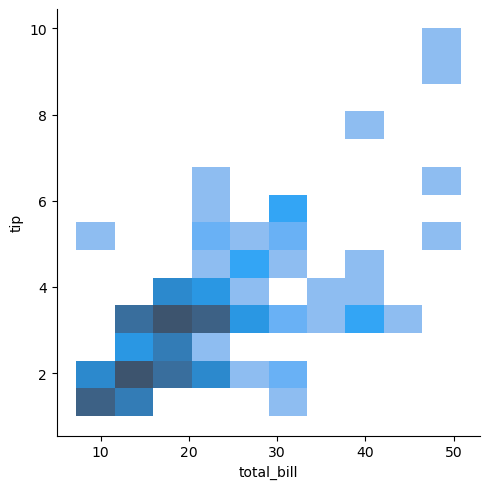

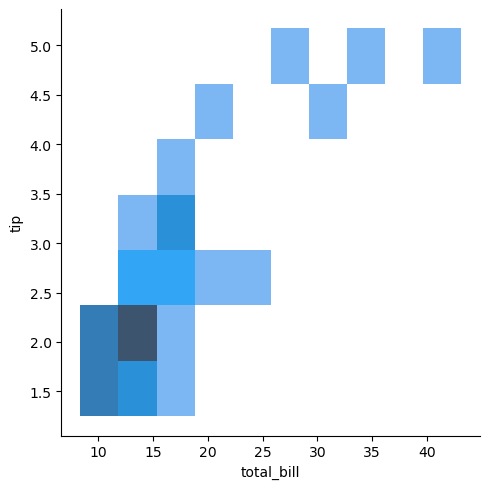

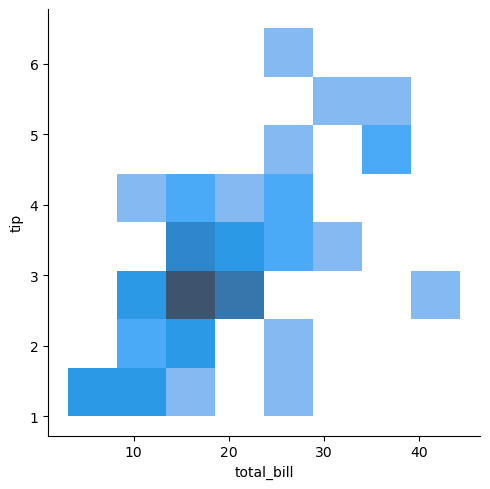

In [65]:
tips = sns.load_dataset("tips")
g = sns.FacetGrid(tips, col="time",  row="sex")
g.map(sns.displot, "total_bill", "tip");

In [66]:
data = {'Class': [0, 1, 1, 1, 1, 0, 1, 0, 1],
        'count': [509, 61, 18, 29, 8, 148, 54, 361, 46],
        'greek_char': ['Alpha', 'Alpha', 'Alpha', 'Alpha', 'Beta', 'Beta', 'Beta', 'Beta', 'Beta'],
        'value': ['A', 'B', 'D', 'G', 'A', 'B', 'B', 'C', 'C']}

df = pd.DataFrame(data)
df

,Class,count,greek_char,value
0,0,509,Alpha,A
1,1,61,Alpha,B
2,1,18,Alpha,D
3,1,29,Alpha,G
4,1,8,Beta,A
5,0,148,Beta,B
6,1,54,Beta,B
7,0,361,Beta,C
8,1,46,Beta,C


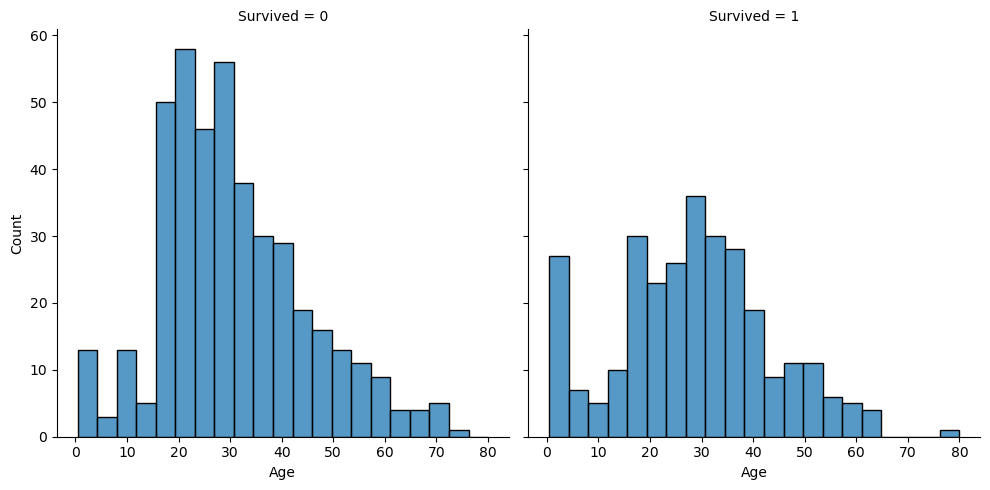

In [67]:
# Explore Age vs Survived
# g = sns.FacetGrid(train, col='Survived')    # Multi-plot grid for plotting conditional relationships.
# g = g.map(sns.displot, 'Age')               # displot가 FacetGrid에 그려지지 않아서 아래 코드로 대체
g = sns.displot(data=train, x='Age', col='Survived');

Age distribution seems to be a tailed distribution, maybe a gaussian distribution.  
  
We notice that age distributions are not the same in the survived and not survived subpopulations. Indeed, there is a peak corresponding to young passengers, that have survived. We also see that passengers between 60-80 have less survived.  
  
So, even if "Age" is not correlated with "Survived", we can see that there is age categories of passengers that of have more or less chance to survive.  
  
It seems that very young passengers have more chance to survive.  
  
__DeepL 번역__  
연령 분포가 꼬리 분포, 즉 가우스 분포인 것 같습니다.  
  
생존한 하위 집단과 생존하지 않은 하위 집단에서 연령 분포가 동일하지 않다는 것을 알 수 있습니다. 실제로 생존한 젊은 승객에 해당하는 정점이 있습니다. 또한 60~80세 사이의 승객은 생존자 수가 적다는 것을 알 수 있습니다.  
  
따라서 '나이'가 '생존'과 상관관계가 없더라도 생존 확률이 높거나 낮은 연령대의 승객이 있다는 것을 알 수 있습니다.  
  
아주 젊은 승객이 생존할 확률이 더 높은 것으로 보입니다.  

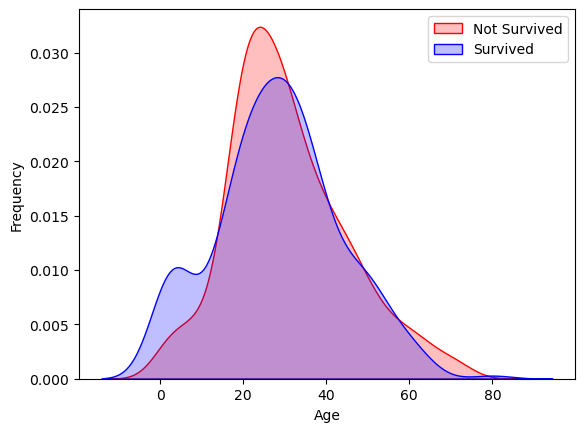

In [68]:
# Explore Age distribution

g = sns.kdeplot(train['Age'][(train['Survived']==0) & (train['Age'].notnull())], color='Red', shade=True)
g = sns.kdeplot(train['Age'][(train['Survived']==1) & (train['Age'].notnull())], color='Blue', shade=True)
g.set_xlabel('Age')
g.set_ylabel('Frequency')
g = g.legend(['Not Survived', 'Survived'])

When we superimpose the two densities , we cleary see a peak correponsing (between 0 and 5) to babies and very young childrens.  
  
__Fare__

In [69]:
dataset['Fare'].isnull().sum()

1

In [70]:
# Fill Fare missing values with median value
dataset['Fare'] = dataset['Fare'].fillna(dataset['Fare'].median())

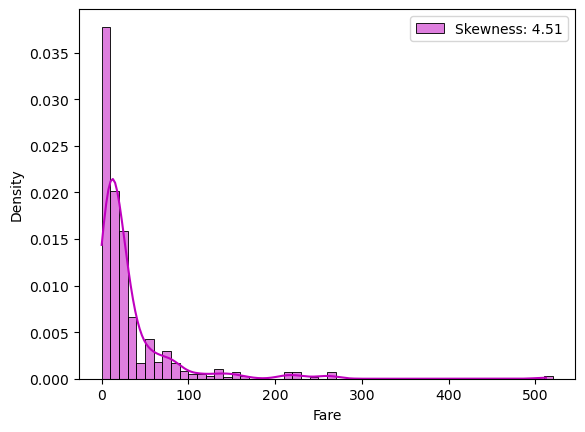

In [71]:
# Since we have one missing value, 
# I decided to fill it with the median value which will not have an important effect on the prediction.

# Explore Fare distribution
# g = sns.distplot(dataset['Fare'], color='m', label='Skewness: %.2f' %dataset['Fare'].skew())
# g = g.legend(loc='best')

# 상기 sns.distplot은 제거 예정으로 아래의 코드 사용
g = sns.histplot(dataset['Fare'], stat='density', color='m', label='Skewness: %.2f' %dataset['Fare'].skew(), kde=True, binwidth=10)
# pd.[DataFrame|Series].skew(): 왜도(skew) 산출, pd.[DataFrame|Series].kurtosis(): 첨도(kurtosis) 산출
g = g.legend(loc='best')

As we can see, Fare distribution is very skewed. This can lead to overweigth very high values in the model, even if it is scaled.  
  
In this case, it is better to transform it with the log function to reduce this skew.

In [72]:
# Apply log to Fare to reduce skewness distribution
dataset['Fare'] = dataset['Fare'].map(lambda i: np.log(i) if i>0 else 0)

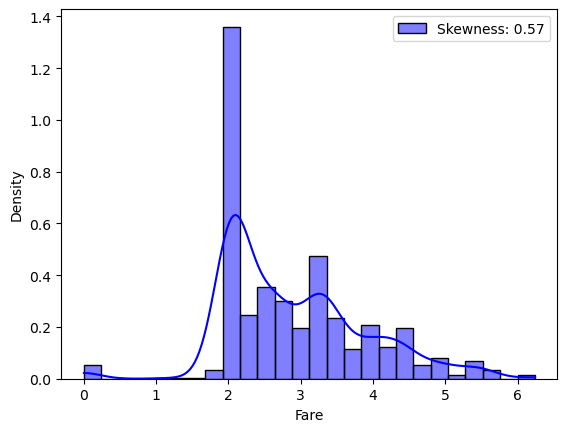

In [73]:
# g = sns.distplot(dataset['Fare'], color='b', label='Skewness: %.2f'%(dataset['Fare'].skew()))
# g = g.legend(loc='best')

# 상기 sns.distplot은 제거 예정으로 아래의 코드 사용
g = sns.histplot(dataset['Fare'], stat='density', color='b', label='Skewness: %.2f' %dataset['Fare'].skew(), kde=True, bins=26)
g = g.legend(loc='best')

Skewness is clearly reduced after the log transformation  
  
## 3.2 Categorical values
__sex__

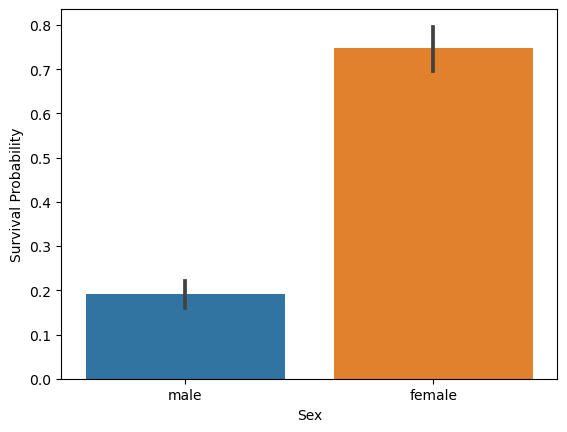

In [74]:
g = sns.barplot(data=train, x='Sex', y='Survived')
g = g.set_ylabel('Survival Probability')

In [75]:
train[['Sex', 'Survived']].groupby('Sex').mean()

,Survived
Sex,
female,0.747573
male,0.190559


It is clearly obvious that Male have less chance to survive than Female.  
  
So Sex, might play an important role in the prediction of the survival.  
  
For those who have seen the Titanic movie (1997), I am sure, we all remember this sentence during the evacuation : "Women and children first".  
  
__Pclass__

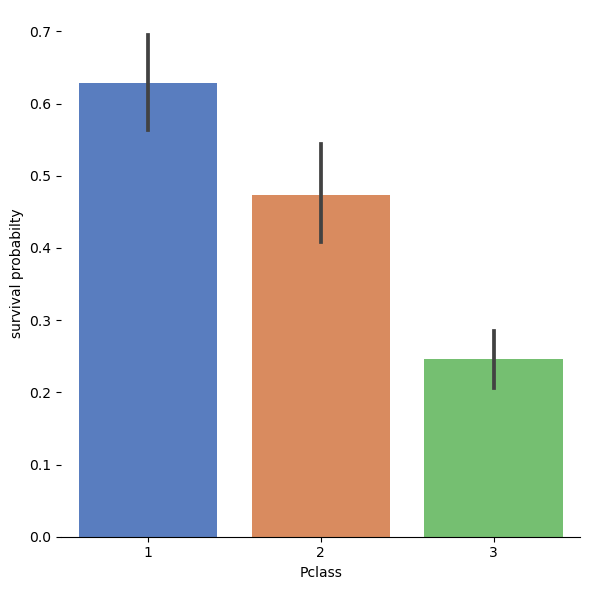

In [76]:
# Explore Pclas vs Survived
g = sns.catplot(data=train, x='Pclass', y='Survived', kind='bar', height=6, palette='muted')
g.despine(left=True)

g = g.set_ylabels('survival probabilty')

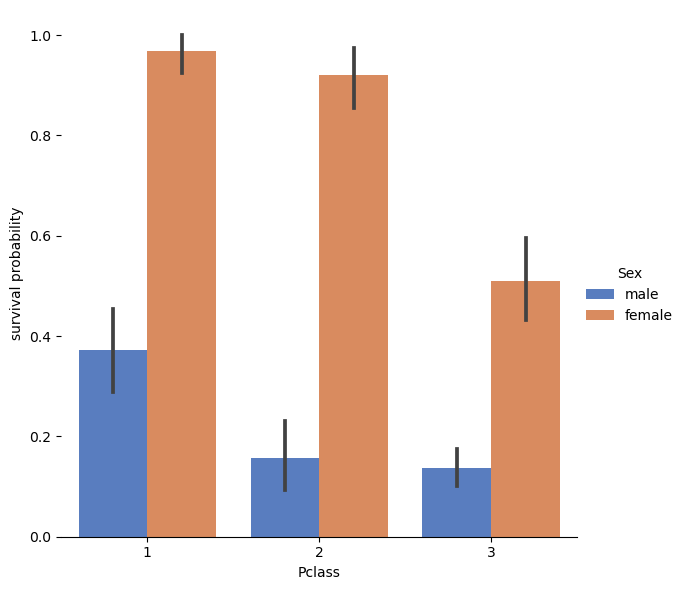

In [77]:
# Explore Pclass vs Survived by Sex
g = sns.catplot(data=train, x='Pclass', y='Survived', hue='Sex', height=6, kind='bar', palette='muted')
g.despine(left=True)
g = g.set_ylabels('survival probability')

The passenger survival is not the same in the 3 classes. First class passengers have more chance to survive than second class and third class passengers.  
  
This trend is conserved when we look at both male and female passengers.  
  
__Embarked__

In [78]:
dataset['Embarked'].isnull().sum()

2

In [79]:
# Fill Embarked nan values of dataset set with 'S' most frequent value
dataset['Embarked'] = dataset['Embarked'].fillna('S')

# Since we have two missing values , i decided to fill them with the most fequent value of "Embarked" (S).

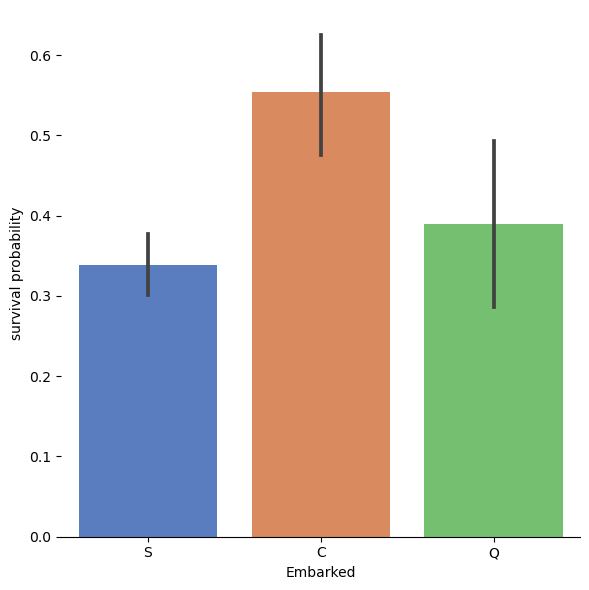

In [80]:
# Explore Embarked vs Survived
g = sns.catplot(data=train, x='Embarked', y='Survived', height=6, kind='bar', palette='muted')
g.despine(left=True)
g = g.set_ylabels('survival probability')

It seems that passenger coming from Cherbourg (C) have more chance to survive.  
  
My hypothesis is that the proportion of first class passengers is higher for those who came from Cherbourg than Queenstown (Q), Southampton (S).  
  
Let's see the Pclass distribution vs Embarked  

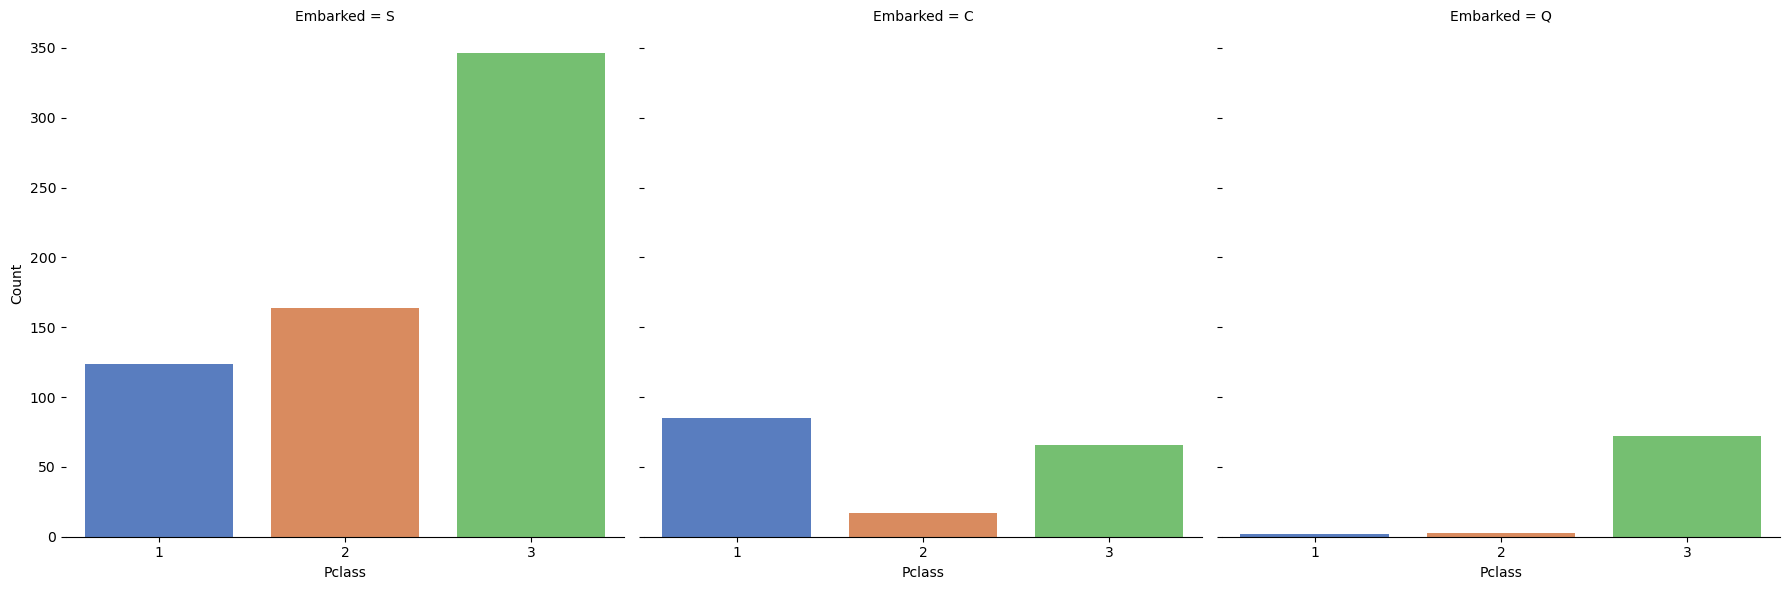

In [81]:
# Explore Pclass vs Embarked
g = sns.catplot(data=train, x='Pclass', col='Embarked', height=6, kind='count', palette='muted')
g.despine(left=True)
g = g.set_ylabels('Count')

Indeed, the third class is the most frequent for passenger coming from Southampton (S) and Queenstown (Q), whereas Cherbourg passengers are mostly in first class which have the highest survival rate.  
  
At this point, i can't explain why first class has an higher survival rate. My hypothesis is that first class passengers were prioritised during the evacuation due to their influence.  
  
# 4. Filling missing Values
## 4.1 Age
As we see, Age column contains 256 missing values in the whole dataset.  
  
Since there is subpopulations that have more chance to survive (children for example), it is preferable to keep the age feature and to impute the missing values.  
  
To adress this problem, i looked at the most correlated features with Age (Sex, Parch , Pclass and SibSP).  
  
__DeepL 번역__  
실제로 사우스햄튼(S)과 퀸스타운(Q)에서 출발하는 승객의 경우 3등석이 가장 많은 반면, 쉘부르 승객은 생존율이 가장 높은 1등석에 주로 탑승하는 것으로 나타났습니다.  
  
현재로서는 일등석의 생존율이 더 높은 이유를 설명할 수 없습니다. 제 가설은 일등석 승객의 영향력으로 인해 대피 시 우선순위가 정해졌기 때문이라고 생각합니다.  
  
# 4. 누락된 값 채우기
## 4.1 나이
보시다시피, 전체 데이터 집합에서 연령 열에는 256개의 누락된 값이 있습니다.  
  
생존 확률이 더 높은 하위 모집단(예: 어린이)이 있기 때문에 연령 기능은 유지하고 누락된 값을 대입하는 것이 바람직합니다.  
  
이 문제를 해결하기 위해 나이와 가장 상관관계가 높은 기능(성별, 파치 , Pclass 및 SibSP)을 살펴봤습니다.

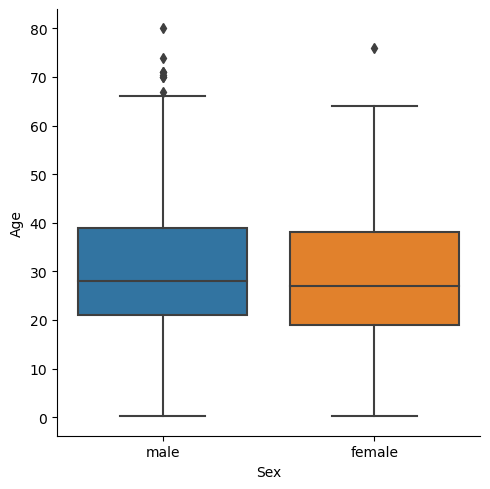

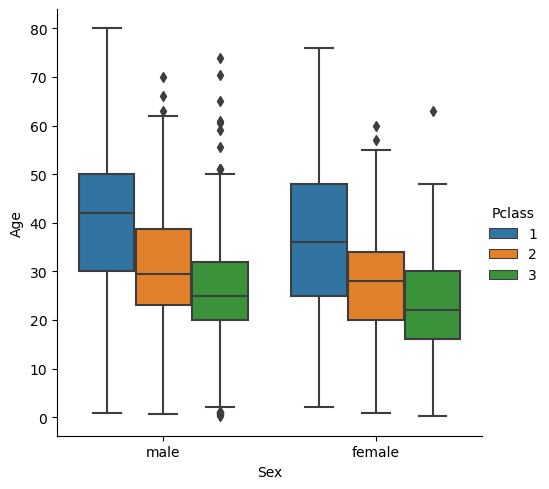

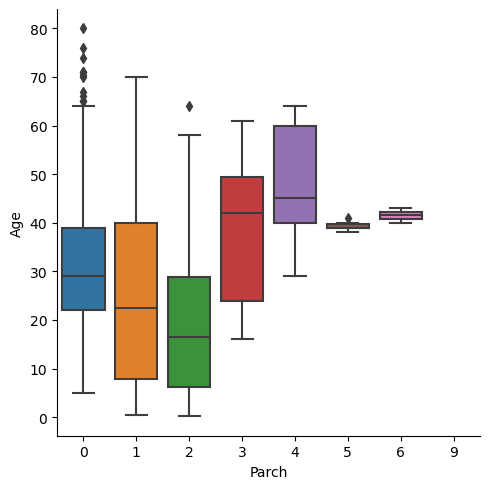

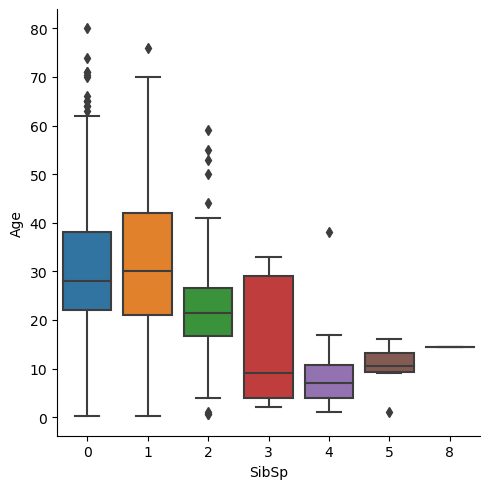

In [82]:
# Explore Age vs Sex, Parch, Pclass and SibSP
g = sns.catplot(data=dataset, x='Sex', y='Age', kind='box')
g = sns.catplot(data=dataset, x='Sex', y='Age', kind='box', hue='Pclass')
g = sns.catplot(data=dataset, x='Parch', y='Age', kind='box')
g = sns.catplot(data=dataset, x='SibSp', y='Age', kind='box')

Age distribution seems to be the same in Male and Female subpopulations, so Sex is not informative to predict Age.
  
However, 1rst class passengers are older than 2nd class passengers who are also older than 3rd class passengers.
  
Moreover, the more a passenger has parents/children the older he is and the more a passenger has siblings/spouses the younger he is.  
  
__DeepL__  
연령 분포는 남성과 여성 하위 집단에서 동일하게 나타나므로 성별은 연령을 예측하는 데 도움이 되지 않습니다.
  
그러나 1등석 승객은 2등석 승객보다 나이가 많고, 2등석 승객은 3등석 승객보다 나이가 많습니다.
  
또한 부모/자녀가 있는 승객은 나이가 많을수록, 형제자매/배우자가 있는 승객은 나이가 적을수록 더 많은 것으로 나타났습니다.

In [83]:
# convert Sex into categorical value 0 for male and 1 for female
dataset['Sex'] = dataset['Sex'].map({'male': 0, 'female': 1})

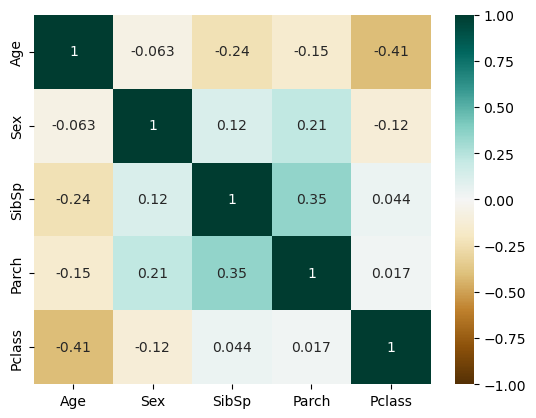

In [84]:
g = sns.heatmap(dataset[['Age', 'Sex', 'SibSp', 'Parch', 'Pclass']].corr(), cmap='BrBG', annot=True, center=0, vmin=-1, vmax=1)
# ceter: 컬러맵 가운데 설정, vmin: 최솟값 설정, vmax: 최댓값 설정

The correlation map confirms the factorplots(categorical plots) observations except for Parch. Age is not correlated with Sex, but is negatively correlated with Pclass, Parch and SibSp.  
  
In the plot of Age in function of Parch, Age is growing with the number of parents / children. But the general correlation is negative.  
  
So, i decided to use SibSP, Parch and Pclass in order to impute the missing ages.  
  
The strategy is to fill Age with the median age of similar rows according to Pclass, Parch and SibSp.  
  
__DeepL 번역__  
상관관계 맵은 Parch를 제외한 요인 플롯(범주형 플롯) 관측치를 확인합니다. 나이는 성별과 상관관계가 없지만 Pclass, Parch 및 SibSp와는 음의 상관관계가 있습니다.  
  
Parch의 함수에 대한 나이의 플롯에서 나이는 부모/자녀의 수에 따라 증가하고 있습니다. 그러나 일반적인 상관관계는 음의 상관관계입니다.  
  
그래서 누락된 나이를 대입하기 위해 SibSP, Parch 및 Pclass를 사용하기로 결정했습니다.  
  
전략은 Pclass, Parch 및 SibSp에 따라 유사한 행의 중간 연령으로 Age를 채우는 것입니다.

In [85]:
# Filling missing value of Age

## Fill Age with the median age of similar rows according to Pclass, parch and SibSp
# Index of NaN age rows
index_NaN_age = list(dataset['Age'][dataset['Age'].isnull()].index)

for i in index_NaN_age:
    age_med = dataset['Age'].median()
    age_pred = dataset['Age'][(dataset['SibSp']==dataset.iloc[i]['SibSp'])&(dataset['Parch']==dataset.iloc[i]['Parch'])&(dataset['Pclass']==dataset.iloc[i]['Pclass'])].median()
    if not np.isnan(age_pred):
        dataset['Age'].iloc[i] = age_pred
    else:
        dataset['Age'].iloc[i] = age_med

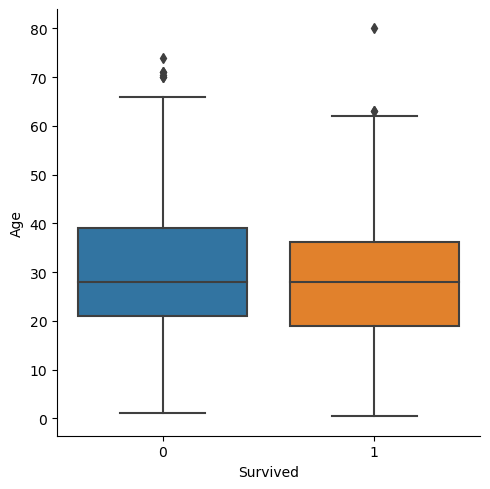

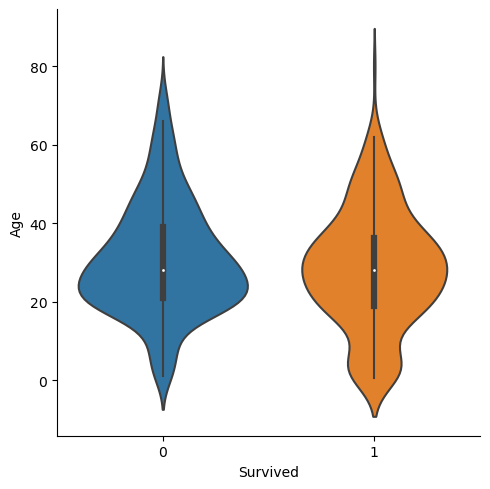

In [86]:
g = sns.catplot(data=train, x='Survived', y='Age', kind='box')
g = sns.catplot(data=train, x='Survived', y='Age', kind='violin')

No difference between median value of age in survived and not survived subpopulation.  
  
But in the violin plot of survived passengers, we still notice that very young passengers have higher survival rate.  
  
# 5. Feature engineering
## 5.1 Name/Title

In [87]:
dataset['Name'].head()

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

The Name feature contains information on passenger's title.  
  
Since some passenger with distingused title may be preferred during the evacuation, it is interesting to add them to the model.  

In [88]:
# Get Title from Name
dataset_title = [i.split(',')[1].split('.')[0].strip() for i in dataset['Name']]
dataset['Title'] = pd.Series(dataset_title)
dataset['Title'].head()

0      Mr
1     Mrs
2    Miss
3     Mrs
4      Mr
Name: Title, dtype: object

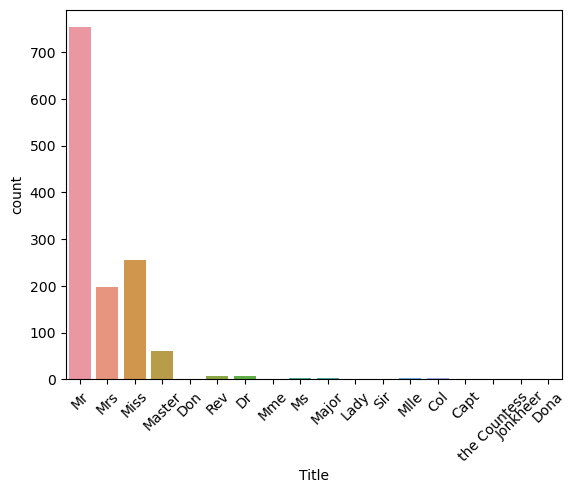

In [89]:
g = sns.countplot(data=dataset, x='Title')
g = plt.setp(g.get_xticklabels(), rotation=45)  # plt.setp: artist(fig)의 속성 설정

In [90]:
dataset['Title'].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'the Countess',
       'Jonkheer', 'Dona'], dtype=object)

In [91]:
# There is 17 titles in the dataset, most of them are very rare and we can group them in 4 categories.

# Convert to categorical values Title
dataset['Title'] = dataset['Title'].replace(['Lady', 'the Countess', 'Countess', 'Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
dataset['Title'] = dataset['Title'].map({'Master': 0, 'Miss': 1, 'Ms': 1, 'Mme': 1, 'Mlle': 1, 'Mrs': 1, 'Mr':2, 'Rare': 3})
dataset['Title'] = dataset['Title'].astype(int)

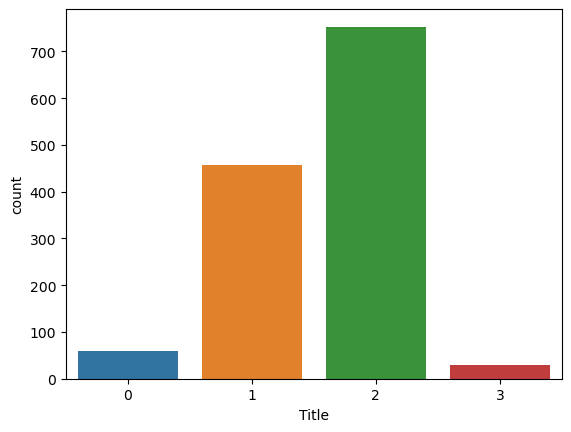

In [106]:
# sns.countplot(dataset['Title'])     # xlabel을 0으로 전체를 count해서 아래 코드 사용
sns.countplot(dataset, x='Title');

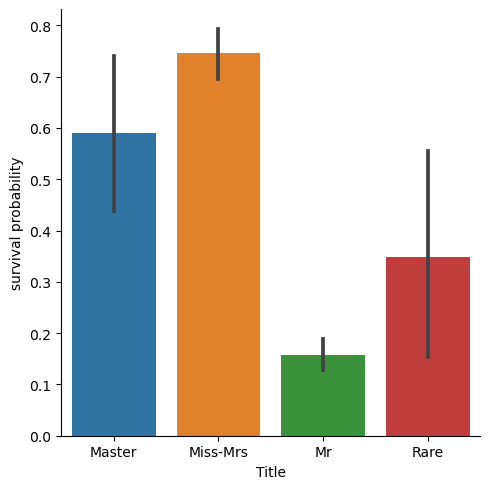

In [107]:
g = sns.catplot(data=dataset, x='Title', y='Survived', kind='bar')
g = g.set_xticklabels(['Master', 'Miss-Mrs', 'Mr', 'Rare'])
g = g.set_ylabels('survival probability')

"Women and children first"  

It is interesting to note that passengers with rare title have more chance to survive.

In [108]:
# Drop Name variable
dataset.drop(labels = ['Name'], axis=1, inplace=True)

## 5.2 Family size
We can imagine that large families will have more difficulties to evacuate, looking for theirs sisters/brothers/parents during the evacuation. So, i choosed to create a "Fize" (family size) feature which is the sum of SibSp , Parch and 1 (including the passenger).  
  
## DeepL 번역
대가족일수록 대피하는 동안 자매/형제/부모를 찾느라 대피에 더 많은 어려움을 겪을 것이라고 상상할 수 있습니다. 그래서 저는 SibSp, Parch, 1(동승자 포함)의 합인 'Fize'(가족 규모) 기능을 만들기로 결정했습니다.

https://www.kaggle.com/code/yassineghouzam/titanic-top-4-with-ensemble-modeling